<a href="https://colab.research.google.com/github/tirth1/medX/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMG_PATH = '/content/gdrive/My Drive/brain tumor/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.87it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 185.48it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 24.73it/s]

50 images loaded from VAL/ directory.


In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

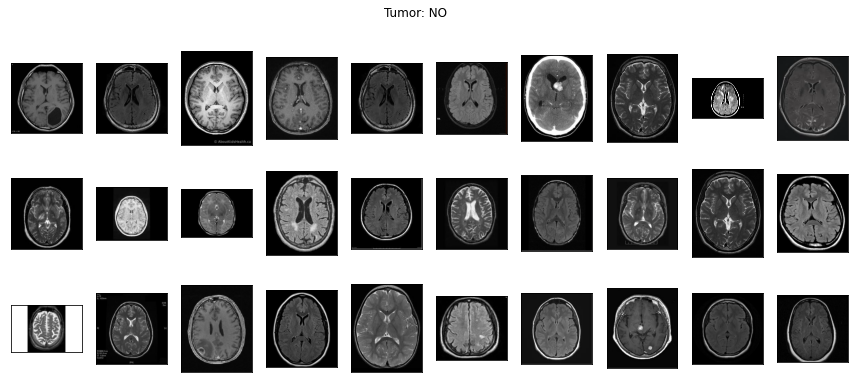

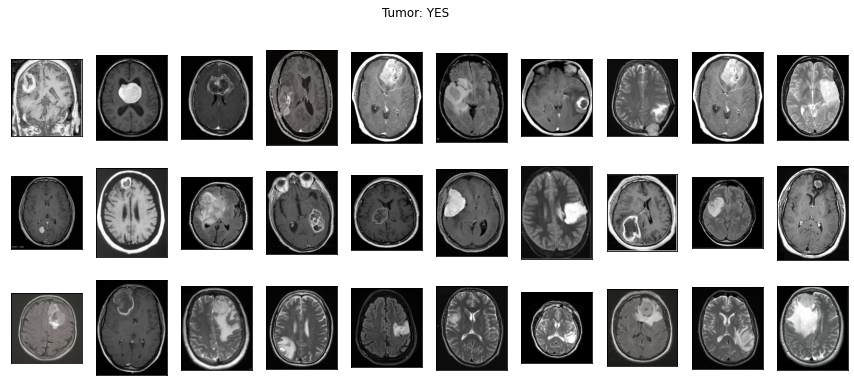

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



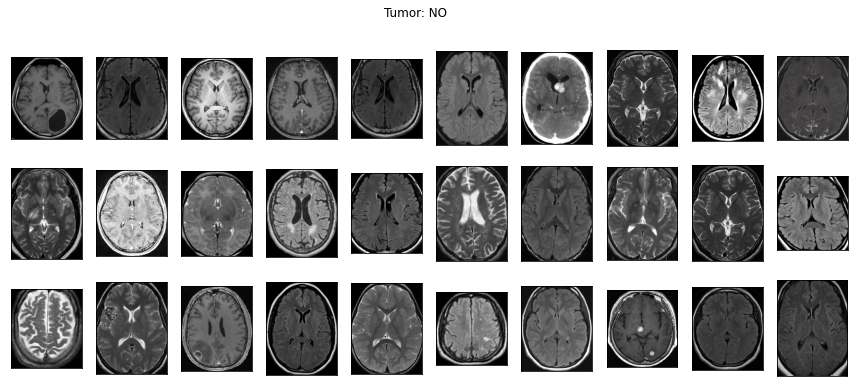

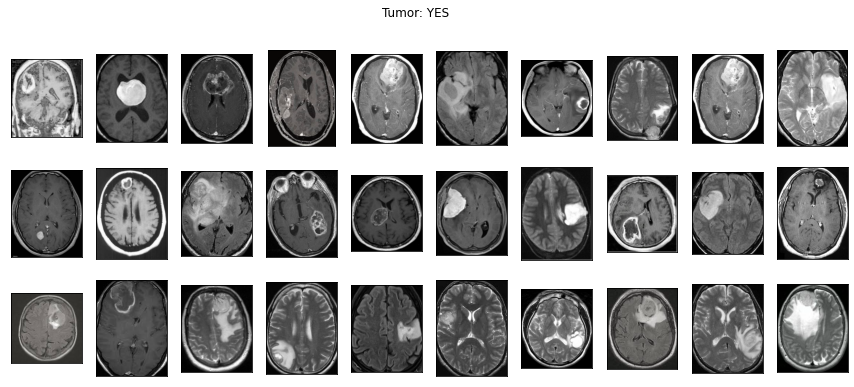

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

# ResNet50

In [ ]:
from keras.applications.resnet import ResNet50, preprocess_input

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
input_t = (224, 224, 3)
resnet50_weight_path = '/content/gdrive/My Drive/pretrain-model-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model_resnet50 = ResNet50(
    weights="imagenet",
    include_top=False, 
    input_shape= input_t
)

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
NUM_CLASSES = 1

model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(layers.Flatten())
model_resnet50.add(layers.Dropout(0.5))
model_resnet50.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_resnet50.layers[0].trainable = False

model_resnet50.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model_resnet50.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 33s 6s/step - loss: 1.5946 - accuracy: 0.5803 - val_loss: 0.7333 - val_accuracy: 0.7600
Epoch 2/30
6/6 [==============================] - 29s 5s/step - loss: 0.9062 - accuracy: 0.7461 - val_loss: 0.5991 - val_accuracy: 0.8000
Epoch 3/30
6/6 [==============================] - 29s 5s/step - loss: 0.9587 - accuracy: 0.6943 - val_loss: 0.6773 - val_accuracy: 0.8000
Epoch 4/30
6/6 [==============================] - 29s 6s/step - loss: 0.7509 - accuracy: 0.7565 - val_loss: 0.5196 - val_accuracy: 0.8600
Epoch 5/30
6/6 [==============================] - 29s 5s/step - loss: 0.6672 - accuracy: 0.7772 - val_loss: 0.4329 - val_accuracy: 0.8200
Epoch 6/30
6/6 [==============================] - 29s 5s/step - loss: 0.5907 - accuracy: 0.7720 - val_loss: 0.5147 - val_accuracy: 0.8600
Epoch 7/30
6/6 [==============================] - 29s 5s/step - loss: 0.6808 - accuracy: 0.7927 - val_loss: 0.4494 - val_accuracy: 0.8400
Epoch 8/30
6/6 [==================

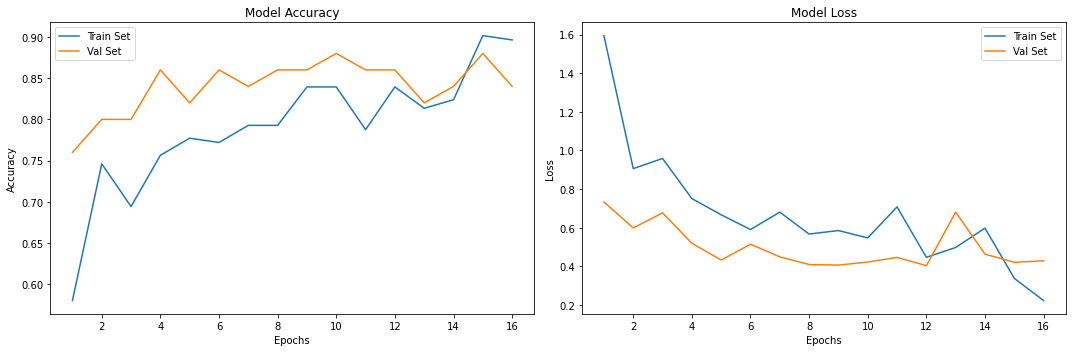

In [ ]:
# plot model performance
acc_resnet50 = history.history['accuracy']
val_acc_resnet50 = history.history['val_accuracy']
loss_resnet50 = history.history['loss']
val_loss_resnet50 = history.history['val_loss']
epochs_range_resnet50 = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_resnet50, acc_resnet50, label='Train Set')
plt.plot(epochs_range_resnet50, val_acc_resnet50, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_resnet50, loss_resnet50, label='Train Set')
plt.plot(epochs_range_resnet50, val_loss_resnet50, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.93


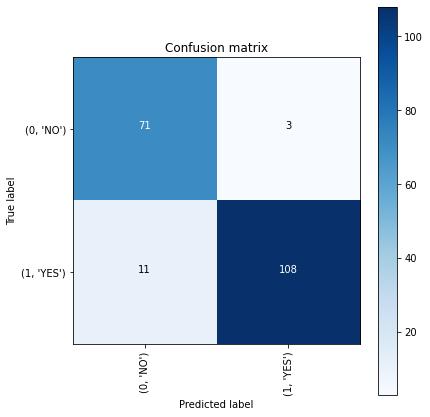

In [ ]:
# validate on train set
predictions_train_resnet50 = model_resnet50.predict(X_train_prep)
predictions_train_resnet50 = [1 if x>0.5 else 0 for x in predictions_train_resnet50]

accuracy_train_resnet50 = accuracy_score(y_train, predictions_train_resnet50)
print('Val Accuracy = %.2f' % accuracy_train_resnet50)

confusion_mtx = confusion_matrix(y_train, predictions_train_resnet50) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.94


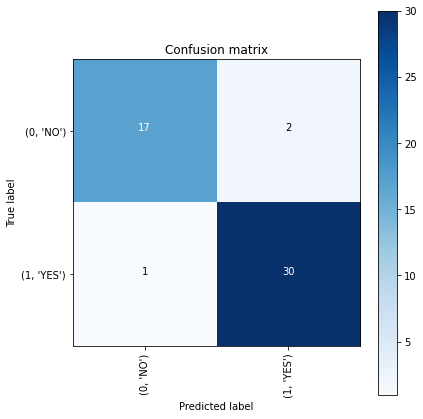

In [ ]:
# validate on val set
predictions_val_resnet50 = model_resnet50.predict(X_val_prep)
predictions_val_resnet50 = [1 if x>0.5 else 0 for x in predictions_val_resnet50]

accuracy_val_resnet50 = accuracy_score(y_val, predictions_val_resnet50)
print('Val Accuracy = %.2f' % accuracy_val_resnet50)

confusion_mtx = confusion_matrix(y_val, predictions_val_resnet50) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.90


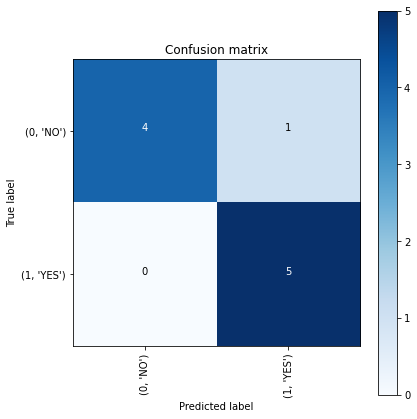

In [ ]:
# validate on test set
predictions_test_resnet50 = model_resnet50.predict(X_test_prep)
predictions_test_resnet50 = [1 if x>0.5 else 0 for x in predictions_test_resnet50]

accuracy_test_resnet50 = accuracy_score(y_test, predictions_test_resnet50)
print('Test Accuracy = %.2f' % accuracy_test_resnet50)

confusion_mtx = confusion_matrix(y_test, predictions_test_resnet50) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# Inception ResNet v2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply inception resnet preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
input_t = (224, 224, 3)
base_model_resnet50 = InceptionResNetV2(
    weights='imagenet',
    include_top=False, 
    input_shape= (224,224,3)
)

219070464/219055592 [==============================] - 4s 0us/step


In [ ]:
NUM_CLASSES = 1

model_inception_resnet = Sequential()
model_inception_resnet.add(base_model_resnet50)
model_inception_resnet.add(layers.Flatten())
model_inception_resnet.add(layers.Dropout(0.5))
model_inception_resnet.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inception_resnet.layers[0].trainable = False

model_inception_resnet.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inception_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 38401     
Total params: 54,375,137
Trainable params: 38,401
Non-trainable params: 54,336,736
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model_inception_resnet.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 59s 8s/step - loss: 0.9830 - accuracy: 0.6114 - val_loss: 0.9669 - val_accuracy: 0.6200
Epoch 2/30
6/6 [==============================] - 45s 9s/step - loss: 0.8603 - accuracy: 0.6425 - val_loss: 0.5573 - val_accuracy: 0.7600
Epoch 3/30
6/6 [==============================] - 46s 8s/step - loss: 0.7632 - accuracy: 0.6528 - val_loss: 0.7294 - val_accuracy: 0.7200
Epoch 4/30
6/6 [==============================] - 47s 8s/step - loss: 0.7916 - accuracy: 0.7047 - val_loss: 0.4554 - val_accuracy: 0.8600
Epoch 5/30
6/6 [==============================] - 46s 8s/step - loss: 0.6392 - accuracy: 0.7617 - val_loss: 0.4098 - val_accuracy: 0.8600
Epoch 6/30
6/6 [==============================] - 45s 8s/step - loss: 0.7324 - accuracy: 0.6943 - val_loss: 0.4463 - val_accuracy: 0.8400
Epoch 7/30
6/6 [==============================] - 45s 8s/step - loss: 0.6448 - accuracy: 0.7409 - val_loss: 0.3691 - val_accuracy: 0.8800
Epoch 8/30
6/6 [==================

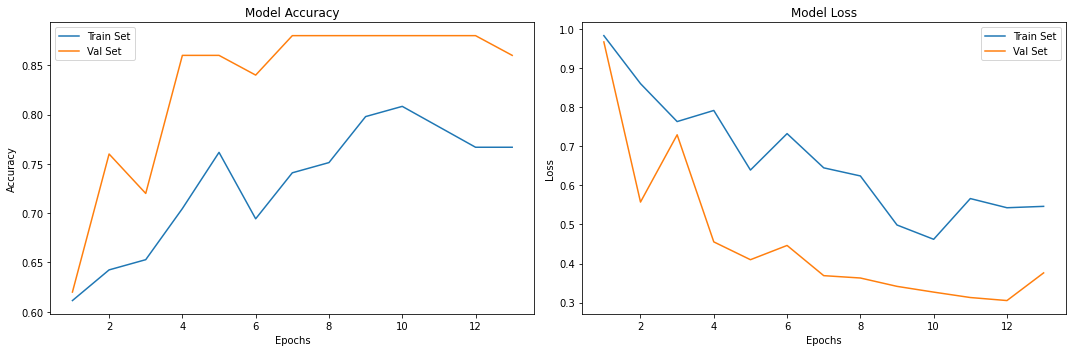

In [ ]:
# plot model performance
acc_inception_resnet = history.history['accuracy']
val_acc_inception_resnet = history.history['val_accuracy']
loss_inception_resnet = history.history['loss']
val_loss_inception_resnet = history.history['val_loss']
epochs_range_inception_resnet = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_inception_resnet, acc_inception_resnet, label='Train Set')
plt.plot(epochs_range_inception_resnet, val_acc_inception_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_inception_resnet, loss_inception_resnet, label='Train Set')
plt.plot(epochs_range_inception_resnet, val_loss_inception_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.89


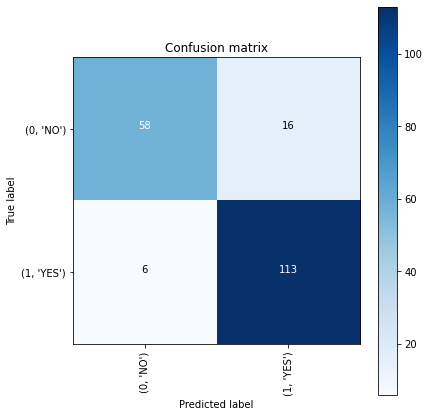

In [ ]:
# validate on train set
predictions_train_inception_resnet = model_inception_resnet.predict(X_train_prep)
predictions_train_inception_resnet = [1 if x>0.5 else 0 for x in predictions_train_inception_resnet]

accuracy_train_inception_resnet = accuracy_score(y_train, predictions_train_inception_resnet)
print('Val Accuracy = %.2f' % accuracy_train_inception_resnet)

confusion_mtx = confusion_matrix(y_train, predictions_train_inception_resnet) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.86


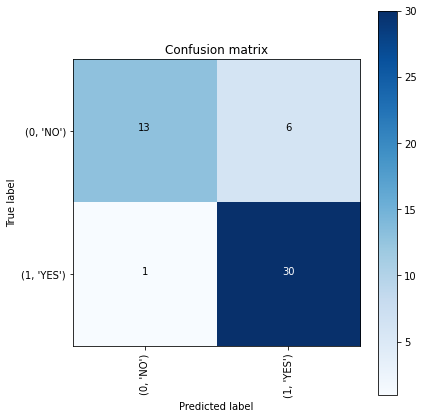

In [ ]:
# validate on val set
predictions_val_inception_resnet = model_inception_resnet.predict(X_val_prep)
predictions_val_inception_resnet = [1 if x>0.5 else 0 for x in predictions_val_inception_resnet]

accuracy_val_inception_resnet = accuracy_score(y_val, predictions_val_inception_resnet)
print('Val Accuracy = %.2f' % accuracy_val_inception_resnet)

confusion_mtx = confusion_matrix(y_val, predictions_val_inception_resnet) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


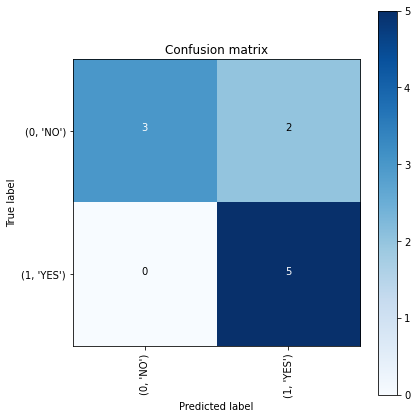

In [ ]:
# validate on test set
predictions_test_inception_resnet = model_inception_resnet.predict(X_test_prep)
predictions_test_inception_resnet = [1 if x>0.5 else 0 for x in predictions_test_inception_resnet]

accuracy_test_inception_resnet = accuracy_score(y_test, predictions_test_inception_resnet)
print('Test Accuracy = %.2f' % accuracy_test_inception_resnet)

confusion_mtx = confusion_matrix(y_test, predictions_test_inception_resnet) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# Xception

In [ ]:
from keras.applications.xception import Xception, preprocess_input

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply Xception preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
input_t = (224, 224, 3)
base_model_xception = Xception(
    weights='imagenet',
    include_top=False, 
    input_shape= input_t
)

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
NUM_CLASSES = 1

model_xception = Sequential()
model_xception.add(base_model_xception)
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_xception.layers[0].trainable = False

model_xception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100353    
Total params: 20,961,833
Trainable params: 100,353
Non-trainable params: 20,861,480
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model_xception.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 40s 6s/step - loss: 0.8696 - accuracy: 0.5959 - val_loss: 0.6281 - val_accuracy: 0.6000
Epoch 2/30
6/6 [==============================] - 35s 6s/step - loss: 0.6201 - accuracy: 0.6943 - val_loss: 0.3917 - val_accuracy: 0.8200
Epoch 3/30
6/6 [==============================] - 35s 6s/step - loss: 0.5389 - accuracy: 0.7254 - val_loss: 0.3807 - val_accuracy: 0.9000
Epoch 4/30
6/6 [==============================] - 34s 6s/step - loss: 0.5015 - accuracy: 0.7617 - val_loss: 0.3429 - val_accuracy: 0.8600
Epoch 5/30
6/6 [==============================] - 35s 6s/step - loss: 0.5231 - accuracy: 0.7668 - val_loss: 0.2891 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 35s 6s/step - loss: 0.3876 - accuracy: 0.8394 - val_loss: 0.2640 - val_accuracy: 0.8800
Epoch 7/30
6/6 [==============================] - 35s 6s/step - loss: 0.3766 - accuracy: 0.8446 - val_loss: 0.2520 - val_accuracy: 0.9000
Epoch 8/30
6/6 [==================

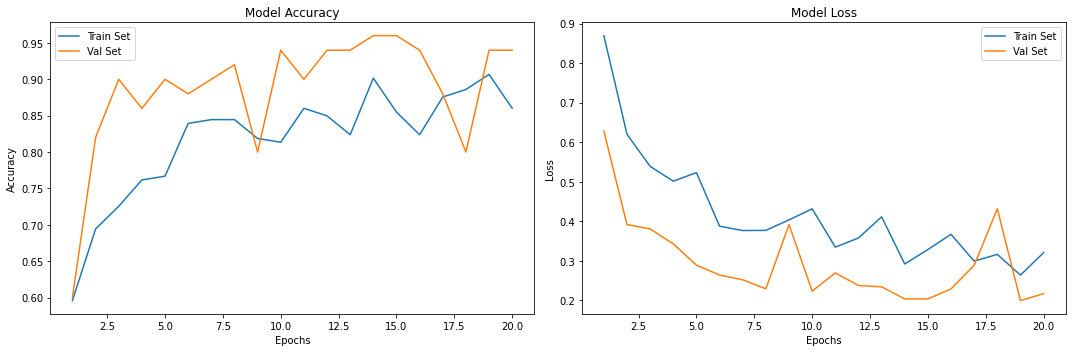

In [ ]:
# plot model performance
acc_xception = history.history['accuracy']
val_acc_xception = history.history['val_accuracy']
loss_xception = history.history['loss']
val_loss_xception = history.history['val_loss']
epochs_range_xception = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_xception, acc_xception, label='Train Set')
plt.plot(epochs_range_xception, val_acc_xception, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_xception, loss_xception, label='Train Set')
plt.plot(epochs_range_xception, val_loss_xception, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.88


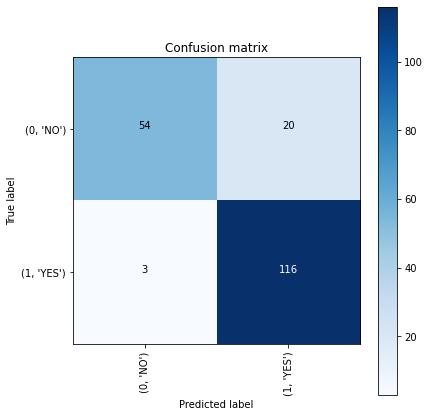

In [ ]:
# validate on train set
predictions_train_xception = model_xception.predict(X_train_prep)
predictions_train_xception = [1 if x>0.5 else 0 for x in predictions_train_xception]

accuracy_train_xception = accuracy_score(y_train, predictions_train_xception)
print('Val Accuracy = %.2f' % accuracy_train_xception)

confusion_mtx = confusion_matrix(y_train, predictions_train_xception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.94


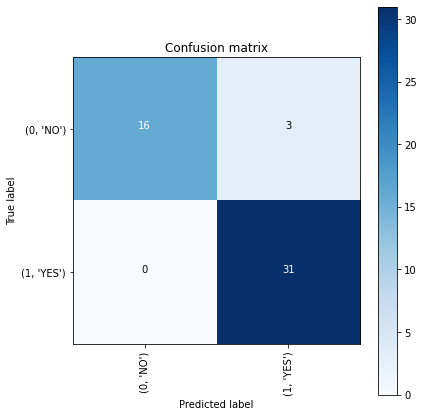

In [ ]:
# validate on val set
predictions_val_xception = model_xception.predict(X_val_prep)
predictions_val_xception = [1 if x>0.5 else 0 for x in predictions_val_xception]

accuracy_val_xception = accuracy_score(y_val, predictions_val_xception)
print('Val Accuracy = %.2f' % accuracy_val_xception)

confusion_mtx = confusion_matrix(y_val, predictions_val_xception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


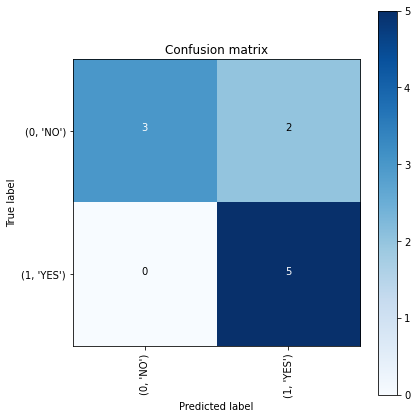

In [ ]:
# validate on test set
predictions_test_xception = model_xception.predict(X_test_prep)
predictions_test_xception = [1 if x>0.5 else 0 for x in predictions_test_xception]

accuracy_test_xception = accuracy_score(y_test, predictions_test_xception)
print('Test Accuracy = %.2f' % accuracy_test_xception)

confusion_mtx = confusion_matrix(y_test, predictions_test_xception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# Inception V3


In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply Inception preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
input_t = (224, 224, 3)
base_model_inception_v3 = InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape= input_t
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

model_inception = Sequential()
model_inception.add(base_model_inception_v3)
model_inception.add(layers.Flatten())
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inception.layers[0].trainable = False

model_inception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model_inception.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 26s 4s/step - loss: 0.8447 - accuracy: 0.5855 - val_loss: 0.5883 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 21s 4s/step - loss: 0.8589 - accuracy: 0.6477 - val_loss: 0.5505 - val_accuracy: 0.7200
Epoch 3/30
6/6 [==============================] - 22s 4s/step - loss: 0.6358 - accuracy: 0.7409 - val_loss: 0.4928 - val_accuracy: 0.8000
Epoch 4/30
6/6 [==============================] - 23s 4s/step - loss: 0.6447 - accuracy: 0.7047 - val_loss: 0.4202 - val_accuracy: 0.8400
Epoch 5/30
6/6 [==============================] - 22s 4s/step - loss: 0.5321 - accuracy: 0.7358 - val_loss: 0.4052 - val_accuracy: 0.8400
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 0.5472 - accuracy: 0.7202 - val_loss: 0.4172 - val_accuracy: 0.8200
Epoch 7/30
6/6 [==============================] - 22s 4s/step - loss: 0.4848 - accuracy: 0.7720 - val_loss: 0.3996 - val_accuracy: 0.8200
Epoch 8/30
6/6 [==================

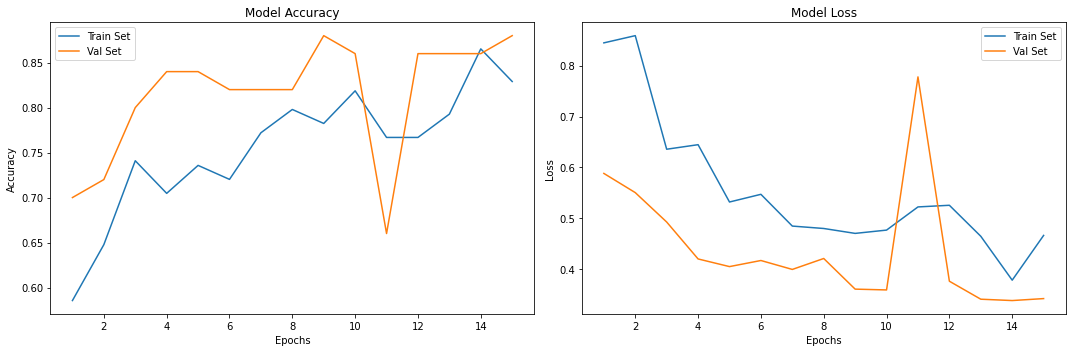

In [ ]:
# plot model performance
acc_inception = history.history['accuracy']
val_acc_inception = history.history['val_accuracy']
loss_inception = history.history['loss']
val_loss_inception = history.history['val_loss']
epochs_range_inception = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_inception, acc_inception, label='Train Set')
plt.plot(epochs_range_inception, val_acc_inception, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_inception, loss_inception, label='Train Set')
plt.plot(epochs_range_inception, val_loss_inception, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.91


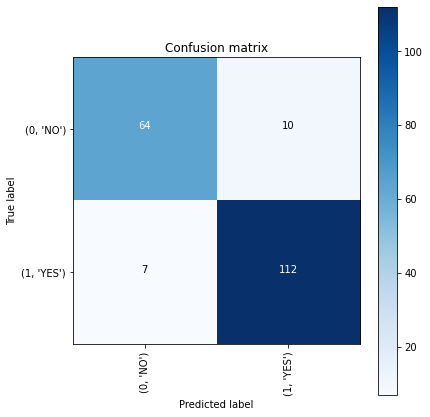

In [ ]:
# validate on train set
predictions_train_inception = model_inception.predict(X_train_prep)
predictions_train_inception = [1 if x>0.5 else 0 for x in predictions_train_inception]

accuracy_train_inception = accuracy_score(y_train, predictions_train_inception)
print('Val Accuracy = %.2f' % accuracy_train_inception)

confusion_mtx = confusion_matrix(y_train, predictions_train_inception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.86


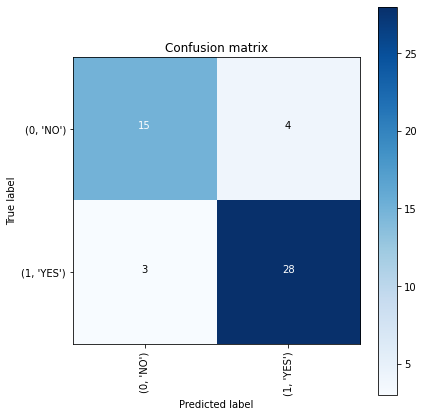

In [ ]:
# validate on val set
predictions_val_inception = model_inception.predict(X_val_prep)
predictions_val_inception = [1 if x>0.5 else 0 for x in predictions_val_inception]

accuracy_val_inception = accuracy_score(y_val, predictions_val_inception)
print('Val Accuracy = %.2f' % accuracy_val_inception)

confusion_mtx = confusion_matrix(y_val, predictions_val_inception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


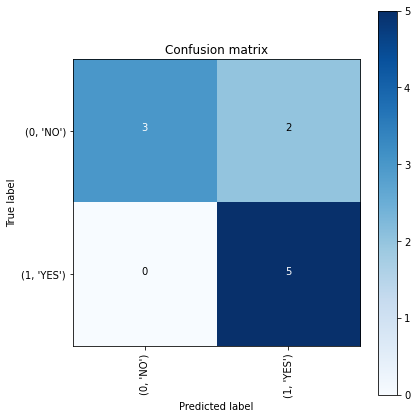

In [ ]:
# validate on test set
predictions_test_inception = model_inception.predict(X_test_prep)
predictions_test_inception = [1 if x>0.5 else 0 for x in predictions_test_inception]

accuracy_test_inception = accuracy_score(y_test, predictions_test_inception)
print('Test Accuracy = %.2f' % accuracy_test_inception)

confusion_mtx = confusion_matrix(y_test, predictions_test_inception) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# VGG-16

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
vgg16_weight_path = '/content/gdrive/My Drive/pretrain-model-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model_vgg16 = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

model_vgg16 = Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_vgg16.layers[0].trainable = False

model_vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model_vgg16.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train_crop)/32,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_val_crop)/16,
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
6/6 [==============================] - 95s 16s/step - loss: 5.0691 - accuracy: 0.5699 - val_loss: 4.3180 - val_accuracy: 0.6400
Epoch 2/30
6/6 [==============================] - 94s 16s/step - loss: 5.2252 - accuracy: 0.5855 - val_loss: 4.0592 - val_accuracy: 0.6200
Epoch 3/30
6/6 [==============================] - 94s 19s/step - loss: 4.6954 - accuracy: 0.6062 - val_loss: 2.3053 - val_accuracy: 0.6800
Epoch 4/30
6/6 [==============================] - 94s 19s/step - loss: 3.7393 - accuracy: 0.6477 - val_loss: 2.9505 - val_accuracy: 0.6400
Epoch 5/30
6/6 [==============================] - 94s 16s/step - loss: 4.0070 - accuracy: 0.6373 - val_loss: 1.4639 - val_accuracy: 0.8400
Epoch 6/30
6/6 [==============================] - 95s 16s/step - loss: 3.6092 - accuracy: 0.7047 - val_loss: 1.2534 - val_accuracy: 0.8600
Epoch 7/30
6/6 [==============================] - 95s 16s/step - loss: 4.0328 - accuracy: 0.6425 - val_loss: 1.0768 - val_accuracy: 0.8600
Epoch 8/30
6/6 [===========

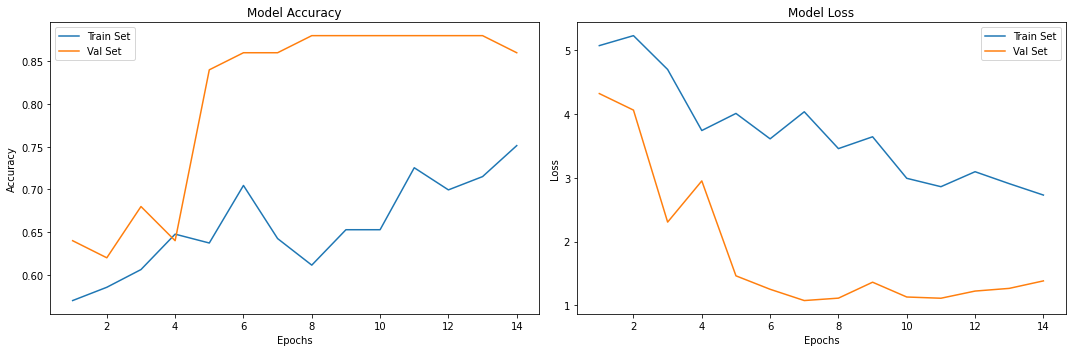

In [ ]:
# plot model performance
acc_vgg16 = history.history['accuracy']
val_acc_vgg16 = history.history['val_accuracy']
loss_vgg16 = history.history['loss']
val_loss_vgg16 = history.history['val_loss']
epochs_range_vgg16 = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg16, acc_vgg16, label='Train Set')
plt.plot(epochs_range_vgg16, val_acc_vgg16, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg16, loss_vgg16, label='Train Set')
plt.plot(epochs_range_vgg16, val_loss_vgg16, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Train Accuracy = 0.84


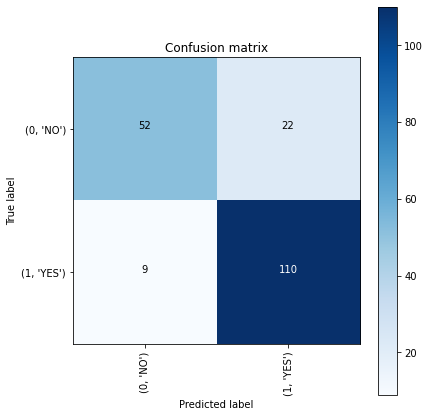

In [ ]:
# validate on train set
predictions_train_vgg16 = model_vgg16.predict(X_train_prep)
predictions_train_vgg16 = [1 if x>0.5 else 0 for x in predictions_train_vgg16]

accuracy_train_vgg16 = accuracy_score(y_train, predictions_train_vgg16)
print('Train Accuracy = %.2f' % accuracy_train_vgg16)

confusion_mtx = confusion_matrix(y_train, predictions_train_vgg16) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Val Accuracy = 0.90


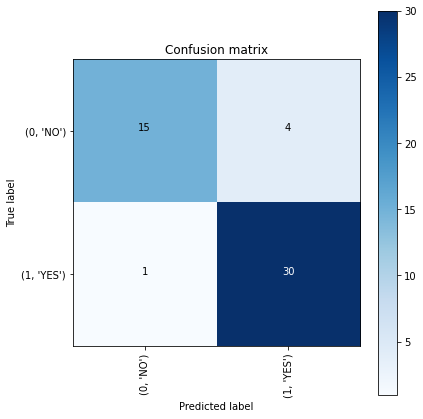

In [ ]:
# validate on val set
predictions_val_vgg16 = model_vgg16.predict(X_val_prep)
predictions_val_vgg16 = [1 if x>0.5 else 0 for x in predictions_val_vgg16]

accuracy_val_vgg16 = accuracy_score(y_val, predictions_val_vgg16)
print('Val Accuracy = %.2f' % accuracy_val_vgg16)

confusion_mtx = confusion_matrix(y_val, predictions_val_vgg16) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.80


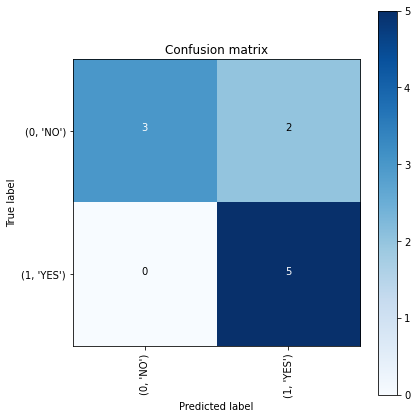

In [ ]:
# validate on test set
predictions_test_vgg16 = model_vgg16.predict(X_test_prep)
predictions_test_vgg16 = [1 if x>0.5 else 0 for x in predictions_test_vgg16]

accuracy_test_vgg16 = accuracy_score(y_test, predictions_test_vgg16)
print('Test Accuracy = %.2f' % accuracy_test_vgg16)

confusion_mtx = confusion_matrix(y_test, predictions_test_vgg16) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
# MODEL_PATH = '/content/gdrive/My Drive/Brain Tumor Classifier Models/'
# model_resnet50.save(MODEL_PATH + 'resnet50_model.h5')
# model_inception_resnet.save(MODEL_PATH + 'inception_resnet_v2_model.h5')
# model_xception.save(MODEL_PATH + 'xception_model.h5')
# model_inception.save(MODEL_PATH + 'inception_v3_model.h5')
# model_vgg16.save(MODEL_PATH + 'vgg16_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
pred = np.array(predictions_test_resnet50) +  np.array(predictions_test_vgg16) + np.array(predictions_test_inception) + np.array(predictions_test_inception_resnet) + np.array(predictions_test_xception)
pred = [1 if x>=3 else 0 for x in pred]
accuracy = accuracy_score(y_test, pred)
print(accuracy)

0.8


In [ ]:
pred = np.array(predictions_val_resnet50)  + np.array(predictions_val_xception) + np.array(predictions_val_inception) + np.array(predictions_val_inception_resnet) + np.array(predictions_val_vgg16)
pred = [1 if x>=3 else 0 for x in pred]
accuracy = accuracy_score(y_val, pred)
print(accuracy)

0.92


In [ ]:
pred = np.array(predictions_train_resnet50) + np.array(predictions_train_xception) + np.array(predictions_train_vgg16) + np.array(predictions_train_inception_resnet) + np.array(predictions_train_inception)
pred = [1 if x>=3 else 0 for x in pred]
accuracy = accuracy_score(y_train, pred)
print(accuracy)

0.9119170984455959


ValueError: ignored

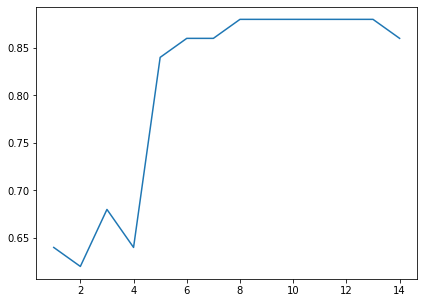

In [ ]:
# plot model performance
acc_vgg16 = history.history['accuracy']
val_acc_vgg16 = history.history['val_accuracy']
loss_vgg16 = history.history['loss']
val_loss_vgg16 = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg16, val_acc_vgg16, label='Val Set')
plt.plot(epochs_range_resnet50, val_acc_resnet50, label='Val Set')
plt.plot(epochs_range_xception, val_acc_xception, label='Val Set')
plt.plot(epochs_range_inception, val_acc_inception, label='Val Set')
plt.plot(epochs_range_inception_resnet, val_acc_inception_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg16, val_loss_vgg16, label='Val Set')
plt.plot(epochs_range_resnet50, val_loss_resnet50, label='Val Set')
plt.plot(epochs_range_xception, val_loss_xception, label='Val Set')
plt.plot(epochs_range_inception, val_loss_inception, label='Val Set')
plt.plot(epochs_range_inception_resnet, val_loss_inception_resnet, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()